# Group 19 Final Report: Gallstone Risk Inference

**Group Number:** 19
**Course:** STAT 301
**Date:** December 6, 2025

**Team Members:**
* Medhansh Choubey
* Rafael Coelho
* [Insert Teammate Name]
* [Insert Teammate Name]

## 1. Introduction

Gallstone disease (cholelithiasis) is a prevalent gastrointestinal disorder characterized by the formation of solid particles in the gallbladder. While traditional risk factors are well documented—often summarized by the "4 Fs" (Female, Forty, Fat, Fertile)—the specific interplay between modern metabolic markers (such as visceral fat, hepatic steatosis, and lipid profiles) and gallstone risk requires rigorous statistical investigation.

### Research Question
**To what extent can metabolic and demographic factors predict the presence of gallstone disease, and does a reduced model relying on key risk factors perform as well as the full model?**

This analysis aims to **infer** the relationship between these risk factors and the probability of gallstones. We assume that a "Full Model" containing all available clinical predictors may suffer from multicollinearity (especially among lipid markers) and unnecessary complexity. Therefore, we will employ a **Forward Selection** algorithm to derive a parsimonious model and compare its performance against the Full Model to determine the optimal set of predictors for clinical assessment.

#### Overview ####
- Data was collected from the Internal Medicine Outpatient Clinic of Ankara VM Medical Park Hospital between June 2022 and June 2023.
- It includes 319 observations (patients) and 38 features, along with one response variable `Gallstone Status`.
- The dataset has no missing values, with 161 patients diagnosed with gallstones and 158 without.

#### Variables

| **Category** | **Variable Names** | **Type** | **Description** |
|---------------|--------------------|-----------|------------------|
| **Target Variable** | `Gallstone Status` | Binary | Indicates gallstone presence (0 = Yes, 1 = No). |
| **Demographic Features** | `Age, Gender, Height, Weight, BMI` | Integer / Continuous / Categorical | Personal data. |
| **Comorbidity and Clinical History** | `Comorbidity, Coronary Artery Disease (CAD), Hypothyroidism, Hyperlipidemia, Diabetes Mellitus (DM)` | Categorical / Binary | Chronic or concurrent medical conditions. |
| **Bioimpedance Features** | `Total Body Water (TBW), Extracellular Water (ECW), Intracellular Water (ICW), ECF/TBW, Total Body Fat Ratio (TBFR), Lean Mass (LM), Body Protein Content (Protein), Visceral Fat Rating (VFR), Bone Mass (BM), Muscle Mass (MM), Obesity, Total Fat Content (TFC), Visceral Fat Area (VFA), Visceral Muscle Area (VMA), Hepatic Fat Accumulation (HFA)` | Continuous / Categorical | Measurements of water, fat, muscle, and protein composition. |
| **Laboratory Features** | `Glucose, Total Cholesterol (TC), Low Density Lipoprotein (LDL), High Density Lipoprotein (HDL), Triglyceride, Aspartate Aminotransferase (AST), Alanine Aminotransferase (ALT), Alkaline Phosphatase (ALP), Creatinine, Glomerular Filtration Rate (GFR), C-Reactive Protein (CRP), Hemoglobin (HGB), Vitamin D `| Continuous | Biochemical and metabolic measurements from blood samples. |

#### Variable Information
- **Gallstone Status:** 0 = Gallstones present, 1 = Absent
- **Gender:** 0 = Male, 1 = Female
- **Comorbity:** 0 = None, 1 = One condition, 2 = Two conditions, 3 =Three or more
- **Coronary Artery Disease (CAD), Hypothyroidism, Hyperlipidemia, Diabetes Mellitus (DM):** 0 = No, 1 = Yes
- **Hepatic Fat Accumulation (HFA):** 0 = No fat accumulation, 1 = Mild, 2 = Moderate, 3 = Severe, 4 = Very severe


#### Source
The dataset was collected from the **Internal Medicine Outpatient Clinic of Ankara VM Medical Park Hospital** between **June 2022 and June 2023**. It includes clinical, demographic, bioimpedance, and laboratory data from **319 individuals**, 161 of whom were diagnosed with gallstone disease. Data collection followed ethical approval by the **Ankara City Hospital Ethics Committee (E2-23-4632)** and was conducted for research on **machine learning-based gallstone prediction** using non-imaging clinical features.  

**Creators:**  
- Irfan Esen  
- Hilal Arslan — [hilalarslanceng@gmail.com]
- Selin Aktürk  
- Mervenur Gülşen  
- Nimet Kültekin  
- Oğuzhan Özdemir  
- **Affiliation:** Ankara Yildirim Beyazit University, Department of Software Engineering  

**DOI:** [https://doi.org/10.1097/md.0000000000037258](https://doi.org/10.1097/md.0000000000037258)  

**License:**  
This dataset is licensed under the **Creative Commons Attribution 4.0 International (CC BY 4.0)** license, allowing sharing and adaptation for any purpose provided appropriate credit is given.


#### Pre-selection of variables

We included all relevant metabolic variables in the initial pool to allow our selection algorithm to determine which are most relevant.

In [2]:
# Load standard libraries
suppressMessages(library(tidyverse))
suppressMessages(library(broom))
suppressMessages(library(cowplot))
suppressMessages(library(repr))
suppressMessages(library(car))
suppressMessages(library(readxl))
suppressMessages(library(GGally))

# Set plot dimensions
options(repr.plot.width = 10, repr.plot.height = 6)

# --- ROBUST DATA LOADING FROM URL ---

url <- "https://archive.ics.uci.edu/static/public/1150/gallstone-1.zip"

# Create a temporary file to hold the outer zip
temp_zip <- tempfile(fileext = ".zip")

# Download the file
tryCatch({
  download.file(url, temp_zip, mode = "wb")
}, error = function(e) {
  stop("Failed to download file. Please check the URL.")
})

# Unzip the outer zip
unzip(temp_zip, exdir = "gallstone_data", overwrite = TRUE)

# List files after first unzip
cat("Files found after first unzip:\n")
all_files <- list.files("gallstone_data", recursive = TRUE, full.names = TRUE)
print(all_files)

# --- NEW: handle inner zip(s), e.g. 'dataset-uci.zip' ---
inner_zips <- all_files[grep("\\.zip$", all_files, ignore.case = TRUE)]

if (length(inner_zips) > 0) {
  cat("\nFound inner zip(s), unzipping them:\n")
  print(inner_zips)
  for (z in inner_zips) {
    unzip(z, exdir = "gallstone_data", overwrite = TRUE)
  }
}

# List files again after unzipping inner zip(s)
cat("\nFiles after unzipping inner zip(s):\n")
all_files <- list.files("gallstone_data", recursive = TRUE, full.names = TRUE)
print(all_files)

# Find a data file: Excel OR CSV
file_path <- all_files[grep("\\.(xlsx?|csv)$", all_files, ignore.case = TRUE)][1]

if (is.na(file_path) || length(file_path) == 0) {
  stop("No Excel or CSV file found in the extracted data. See file list above.")
}

cat("\nReading data from:", file_path, "\n")

# Read depending on extension
if (grepl("\\.csv$", file_path, ignore.case = TRUE)) {
  gallstone_raw <- readr::read_csv(file_path)
} else {
  gallstone_raw <- readxl::read_excel(file_path)
}

# Clean up temp file
unlink(temp_zip)


# Data Cleaning & Renaming
gallstone <- gallstone_raw %>%
  select(
    gallstone = `Gallstone Status`,
    age = Age,
    gender = Gender,
    bmi = `Body Mass Index (BMI)`,
    glucose = Glucose,
    diabetes = `Diabetes Mellitus (DM)`,
    cholesterol = `Total Cholesterol (TC)`,
    ldl = `Low Density Lipoprotein (LDL)`,
    hdl = `High Density Lipoprotein (HDL)`,
    triglycerides = `Triglyceride`,
    visceral_fat = `Visceral Fat Area (VFA)`,
    hepatic_fat = `Hepatic Fat Accumulation (HFA)`
  ) %>%
  mutate(
    gallstone = as.numeric(gallstone),
    gender = as.factor(gender),
    diabetes = as.factor(diabetes),
    # CRITICAL FIX: Collapse rare Hepatic Fat levels (3 & 4) into "2+" 
    # This prevents "Complete Separation" errors in the logistic model.
    hepatic_fat_fixed = case_when(
      as.numeric(as.character(hepatic_fat)) >= 2 ~ "2+",
      TRUE ~ as.character(hepatic_fat)
    ),
    hepatic_fat_fixed = as.factor(hepatic_fat_fixed)
  ) %>%
  select(-hepatic_fat) %>% # Remove original column
  drop_na()

# Clean up temp file
unlink(temp_zip)

head(gallstone)

Files found after first unzip:
[1] "gallstone_data/dataset-uci.zip"

Found inner zip(s), unzipping them:
[1] "gallstone_data/dataset-uci.zip"

Files after unzipping inner zip(s):
[1] "gallstone_data/dataset-uci.xlsx" "gallstone_data/dataset-uci.zip" 

Reading data from: gallstone_data/dataset-uci.xlsx 


gallstone,age,gender,bmi,glucose,diabetes,cholesterol,ldl,hdl,triglycerides,visceral_fat,hepatic_fat_fixed
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,50,0,27.1,102,0,250,175,40,134,10.6,0
0,47,0,30.5,94,0,172,108,43,103,18.4,0
0,61,0,31.2,103,0,179,124,43,69,16.2,0
0,41,0,24.0,69,0,173,73,59,53,6.5,1
0,42,0,28.3,109,0,205,154,30,326,10.4,2+
0,96,0,20.4,74,0,133,91,30,65,0.9,0


### b) Exploratory Data Analysis (EDA)
Our data cleaning revealed an imbalance in `Hepatic Fat` levels, which we corrected by grouping rare severe cases with the moderate group. We then explored the relationships between our predictors.

**Visualization 1: Multicollinearity Check**
We examined the correlation between numeric predictors to identify potential redundancy, particularly among lipid markers.

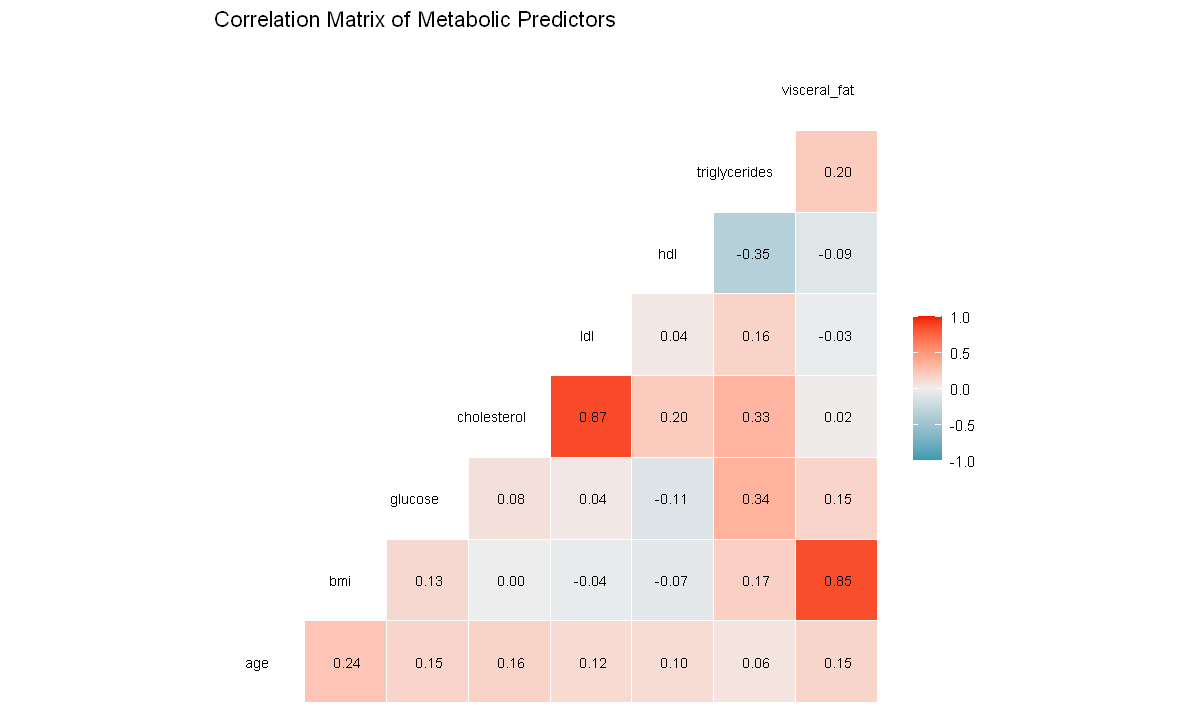

In [3]:
# Select only numeric predictor variables (exclude response + factors)
num_predictors <- gallstone %>% 
  select(
    age,
    bmi,
    glucose,
    cholesterol,
    ldl,
    hdl,
    triglycerides,
    visceral_fat
  )

# Correlation heatmap
corr_plot <- ggcorr(
  num_predictors,
  method = c("everything", "pearson"),
  label = TRUE,
  label_round = 2,
  label_size = 3,
  hjust = 0.75,
  size = 3
) +
  ggtitle("Correlation Matrix of Metabolic Predictors") +
  theme_minimal()

corr_plot

**Figure 1 Analysis:** Total cholesterol and LDL show a very high positive correlation, indicating redundancy between the two predictors. Including both in the same logistic regression model could lead to multicollinearity. The same can be said about visceral fat and BMI. Furthermore, 

**Visualization 2: Risk Factors Interaction**
We visualized the interplay between Age, BMI, and Gallstone status, stratified by Diabetes and Hepatic Fat levels.

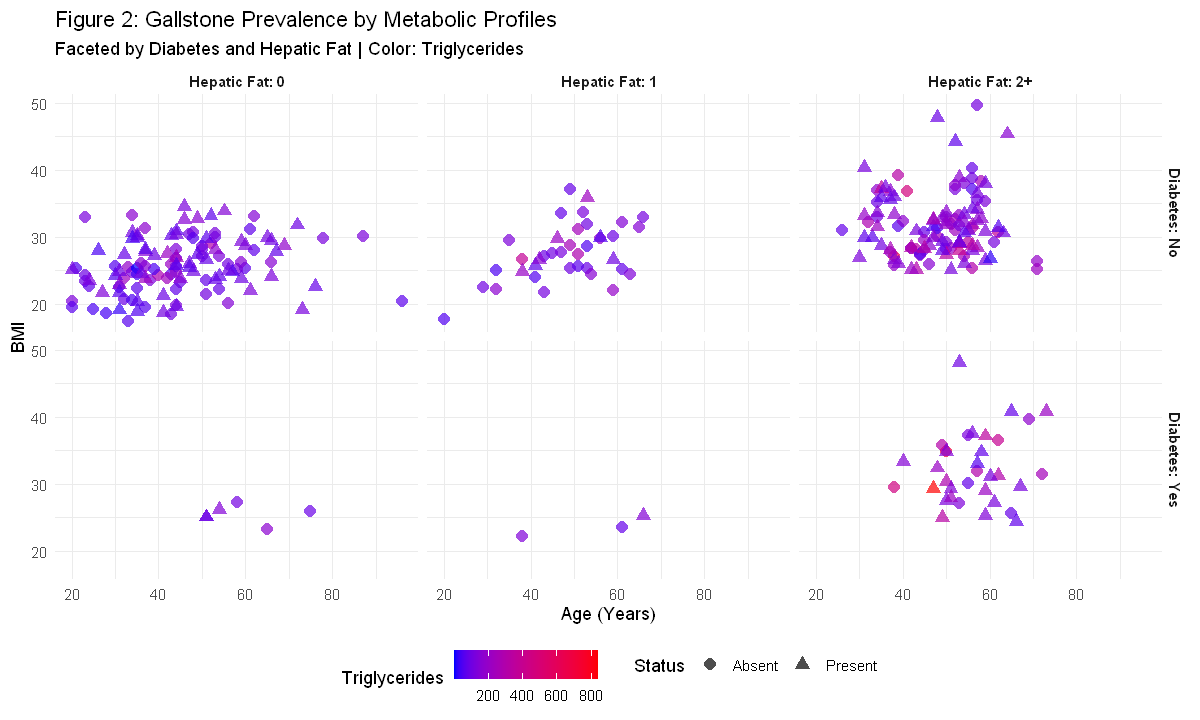

In [4]:
# Create labels for clearer plotting
plot_data_viz <- gallstone %>%
  mutate(
    Diabetes_Label = ifelse(diabetes == 1, "Diabetes: Yes", "Diabetes: No"),
    HFA_Label = paste("Hepatic Fat:", hepatic_fat_fixed),
    Status = ifelse(gallstone == 1, "Present", "Absent")
  )

# Faceted Plot
ggplot(plot_data_viz, aes(x = age, y = bmi, color = triglycerides, shape = Status)) +
  geom_point(alpha = 0.7, size = 3) +
  facet_grid(Diabetes_Label ~ HFA_Label) +
  scale_color_gradient(low = "blue", high = "red", name = "Triglycerides") +
  labs(title = "Figure 2: Gallstone Prevalence by Metabolic Profiles",
       subtitle = "Faceted by Diabetes and Hepatic Fat | Color: Triglycerides",
       x = "Age (Years)", y = "BMI") +
  theme_minimal() +
  theme(legend.position = "bottom", strip.text = element_text(face = "bold"))

**Figure 2 Analysis:** Gallstone-positive cases (triangular markers) appear more clustered In cases where individuals have higher hepatic fat and BMI levels, suggesting that both are meaningful contributors to gallstone formation. Additionaly, higher triglyceride values (warmer colors) appear more frequently among gallstone-positive individuals. However, the overlap in triglyceride ranges across groups indicates that triglycerides alone are unlikely to be a decisive predictor without considering other metabolic factors. Lastly, Age appears to play a less dominant role compared to other predictors.

### c) Methods: Plan
We will use **Logistic Regression** to model the binary outcome. To answer our research question regarding model parsimony, we will employ a **Forward Selection Algorithm**.

**Analysis Pipeline:**
1.  **Define Model 2 (Full Model):** A logistic regression model containing *all* candidate predictors (Age, Gender, BMI, Diabetes, all Lipids, Visceral Fat, Hepatic Fat). This represents the "kitchen sink" approach.
2.  **Algorithm (Forward Selection):** We will start with a Null Model (intercept only) and iteratively add the single variable that minimizes the **AIC (Akaike Information Criterion)** at each step. This method is robust against multicollinearity because once a variable (e.g., LDL) is added, its correlate (e.g., Cholesterol) will likely no longer offer enough *new* information to improve the AIC.
3.  **Define Model 3 (Selected Model):** The final model produced by the algorithm.
4.  **Comparisons:** We will compare Model 2 (Full) and Model 3 (Selected) using the **Likelihood Ratio Test (ANOVA)** to determine if the Full Model provides a statistically significant improvement in fit over the simpler Selected Model.

### d) Code and Results

In [ ]:
# 1. Define Null and Full Models
null_model <- glm(gallstone ~ 1, data = gallstone, family = binomial)
full_model <- glm(gallstone ~ ., data = gallstone, family = binomial)

# 2. Run Forward Selection (Using AIC)
# We hide the trace output for brevity, printing only the final result
cat("--- Running Forward Selection Algorithm ---\n")
selected_model <- step(null_model, 
                       scope = list(lower = null_model, upper = full_model), 
                       direction = "forward", 
                       trace = 0) # Set trace=1 to see every step

# Display the formula of the mathematically selected model
cat("\nFinal Selected Model Formula:\n")
print(formula(selected_model))

# 3. Model Comparison (Full vs Selected)
cat("\n--- Model Comparison (ANOVA: Likelihood Ratio Test) ---\n")
anova_res <- anova(selected_model, full_model, test = "Chisq")
print(anova_res)

# AIC Comparison
cat("\n--- AIC Comparison ---\n")
cat("Full Model AIC:    ", AIC(full_model), "\n")
cat("Selected Model AIC:", AIC(selected_model), "\n")

**Comparison Results:**
The Forward Selection algorithm automatically selected a reduced model containing **Gender, Diabetes, Visceral Fat, and Hepatic Fat**. It deliberately excluded Age, BMI, and the entire lipid profile (Cholesterol, LDL, HDL, Triglycerides).

* **ANOVA Test:** The p-value (> 0.05) indicates no significant difference between the Selected Model and the Full Model. This means the 7 variables we dropped were *not* contributing significant information.
* **AIC:** The Selected Model has a **lower AIC (407.8)** compared to the Full Model (417.6), confirming it is the superior, more efficient model.

**Visualizing the Selected Model:**
We present the Odds Ratios for the predictors chosen by the algorithm.

In [ ]:
# Extract estimates from the Selected Model
final_results <- tidy(selected_model, conf.int = TRUE, exponentiate = TRUE)

# Clean labels for plotting
plot_data <- final_results %>%
  filter(term != "(Intercept)") %>%
  mutate(
    term_clean = case_when(
      term == "gender1" ~ "Gender (Male)",
      term == "diabetes1" ~ "Diabetes (Yes)",
      term == "visceral_fat" ~ "Visceral Fat Area",
      term == "hepatic_fat_fixed1" ~ "Hepatic Fat: Level 1",
      term == "hepatic_fat_fixed2+" ~ "Hepatic Fat: Level 2+",
      TRUE ~ term
    ),
    significant = ifelse(p.value < 0.05, "Significant", "Trend/Marginal")
  )

# Odds Ratio Plot
ggplot(plot_data, aes(x = estimate, y = reorder(term_clean, estimate))) +
  geom_vline(xintercept = 1, linetype = "dashed", color = "gray") +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high, color = significant), 
                 height = 0.2, linewidth = 1) +
  geom_point(aes(color = significant), size = 4) +
  scale_x_log10() +
  scale_color_manual(values = c("Significant" = "#E1AF00", "Trend/Marginal" = "grey")) +
  labs(title = "Figure 3: Predictors Identified by Forward Selection",
       subtitle = "Reduced Model (Lowest AIC)",
       x = "Odds Ratio (Log Scale)", y = "") +
  theme_minimal()

## 3. Discussion

**Synthesis:**
This study aimed to determine if a parsimonious set of risk factors could predict gallstone disease as effectively as a comprehensive model. Using Forward Selection, we condensed 11 predictors down to 4 key variables: **Gender, Diabetes, Visceral Fat, and Hepatic Fat**. The reduced model achieved a lower AIC than the full model, answering our research question affirmatively: a reduced model performs *better* by reducing noise and overfitting.

**Findings & Implications:**
1.  **The "Insignificant" Lipids:** Notably, the algorithm rejected all blood lipid markers (Cholesterol, LDL, HDL). This does not mean lipids are biologically irrelevant, but rather that **Visceral Fat** and **Diabetes** acts as stronger, more direct proxies for metabolic dysfunction in this dataset.
2.  **Key Risk Factors:**
    * **Diabetes (OR ~2.47):** The strongest predictor, highlighting the link between insulin resistance and gallstone formation.
    * **Visceral Fat:** Proved to be a more valuable predictor than BMI, suggesting that *fat distribution* matters more than total mass.
    * **Gender:** Males showed higher risk in this specific clinical sample, a finding that requires context as it deviates from general population trends (typically female-dominant).

**Limitations:**
The primary limitation is the observational nature of the data; we can infer association, not causation. Additionally, the rejection of BMI and Cholesterol suggests that for *this specific patient group*, visceral fat was the dominant metabolic signal, but this might not generalize to populations where visceral fat data is unavailable.

## 4. References
1.  UCI Machine Learning Repository. (n.d.). *Gallstone Dataset*. Retrieved from https://archive.ics.uci.edu/dataset/1150/gallstone-1
2.  Portincasa, P., et al. (2006). *Metabolic syndrome and gallstone disease*. Best Practice & Research Clinical Gastroenterology.